# Script for computing spacings

Reference: [Nikki Loppi thesis](https://spiral.imperial.ac.uk/handle/10044/1/73888)


$$Re = \frac{ρ U L}{\mu} = \frac{U L}{\nu} $$ 

In [2]:
Re_x = 1.2e6 # From Loppi thesis
U_inf = 1    # Set for ease of computations
rho = 1      # Set for ease of computations

# Submarine lengths
# In Fidelity Pointwise, find these with Ctrl+Shift+MMB
L_x_all  = 14.29166
L_x_sail = 1.208333
L_x_stern = 0.5

# Solver 
order = 4    
# As per Sambit's bandwitdh benchmarking paper, 
#   order 5 is optimal, 
#   order 6 sees performance drops on H100s and PVCs.

In [3]:
nu_all = rho*U_inf*L_x_all/Re_x
Re_x_sail = rho*U_inf*L_x_sail/nu_all
Re_x_stern = rho*U_inf*L_x_stern/nu_all

print("Set in PyFR *.ini file [constants] nu = ", nu_all)
print("Sail Reynolds number: Re = ", Re_x_sail)
print("Stern Reynolds number: Re = ", Re_x_stern)

Set in PyFR *.ini file [constants] nu =  1.1909716666666667e-05
Sail Reynolds number: Re =  101457.7452864118
Stern Reynolds number: Re =  41982.52687231574


In [4]:
print("Boundary layer thickness δ₉₉")
#https://youtu.be/1gSHN99I7L4?si=_k-JDRMkmgwi95E7&t=1351

print("Hull:", 0.38*L_x_all/Re_x**0.2)
print("Sail:", 0.38*L_x_sail/Re_x_sail**0.2)
print("Stern:", 0.38*L_x_stern/Re_x_stern**0.2)

Boundary layer thickness δ₉₉
Hull: 0.33039238055753517
Sail: 0.045783942941828026
Stern: 0.022601636505172776


## Loppi's $y^+$

### From Loppi's thesis ...
... The boundary layer blocks were generated such that the first P = 4 Gauss-Legendre solution point is at approximately

$$z^+ = \frac{u^\tau\ z}{\mu} = 2.5$$
 with $u\tau = \sqrt{\tau_w}$ being the wall-shear stress reported in reference: Posa and E. Balaras, “A numerical investigation of the wake of an axisym- metric body with appendages,” Journal of Fluid Mechanics, vol. 792, pp. 470– 498, 2016 ...
 

## Low-order $Δy$ spacing

Reference: https://www.cadence.com/en_US/home/tools/system-analysis/computational-fluid-dynamics/y-plus.html

Assumption: Flat-plate boundary layer theory from Frank M. White's Fluid Mechanics 5th edition, page 467.

In [5]:
print("Loppi used y⁺:", 2.5)
y_plus = 1
print("I shall use y⁺:", y_plus)

# Overall
C_f = 0.026/Re_x**(1/7)
tau_wall = C_f*0.5*rho*U_inf**2
U_fric = (tau_wall/rho)**0.5
delta_y_all = y_plus*nu_all/U_fric
print("Complete Submarine: Δyₕᵤₗₗ = ", delta_y_all)

# Sail
C_f = 0.026/Re_x_sail**(1/7)
tau_wall = C_f*0.5*rho*U_inf**2
U_fric = (tau_wall/rho)**0.5
delta_y_sail = y_plus*nu_all/U_fric

print("Sail: ", delta_y_sail)

C_f = 0.026/Re_x_stern**(1/7)
tau_wall = C_f*0.5*rho*U_inf**2
U_fric = (tau_wall/rho)**0.5
delta_y_stern = y_plus*nu_all/U_fric
print("Stern: ", delta_y_stern)


Loppi used y⁺: 2.5
I shall use y⁺: 1
Complete Submarine: Δyₕᵤₗₗ =  0.00028389450428495866
Sail:  0.0002379696402281843
Stern:  0.00022343383380027743


## High-order

### $y^+$ spacing

Assuming we use hexahedral elements [Gauss-Legendre quadrature points](https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_quadrature), the high-order element may be chosen to be larger than the low-order spacing we just got. Rule of thumb is to multiply the obtained low-order $y^+$ by the element size (anyways we use Flat-plate assumption and these numbers are best obtained after a few simulation runs iteratively). 

In [6]:
# Keeping first point location by Gauss-Legendre quadrature in one place
# Get the numbers from: https://pomax.github.io/bezierinfo/legendre-gauss.html

first_point_loc = {0: 0.0, 1: 0.57735, 2: 0.774597, 3: 0.861136, 4: 0.90618, 5:0.9324695142031521, 6:0.9491079123427585}

Normalised_cell_height_multiplier = [2/(1-x) for x in first_point_loc.values()]
print(Normalised_cell_height_multiplier)

[2.0, 4.7320477936827166, 8.872996366507987, 14.402580942504898, 21.317416329140904, 29.616253702314577, 39.29883980138545]


In [7]:
s_all = delta_y_all*Normalised_cell_height_multiplier[order]
s_sail = delta_y_sail*Normalised_cell_height_multiplier[order]
s_stern = delta_y_stern*Normalised_cell_height_multiplier[order]
ar_high_pressure_variation = 1
ar_low_pressure_variation = 5

#print("y⁺ spacing: ", s_all, s_sail, s_stern)
print("High order Δy spacing:")
print("\tComplete Submarine: \t", s_all)
print("\tSail: \t\t\t", s_sail)
print("\tStern: \t\t\t", s_stern)

print("\nAspect ratio at pressure-variation dominant tips: ", ar_high_pressure_variation)
print("\nHigh order Δx spacing at pressure-variation dominant tips:")
print("\tHull tip: \t", s_all*ar_high_pressure_variation)
print("\tSail tip: \t", s_sail*ar_high_pressure_variation)
print("\tStern tip: \t", s_stern*ar_high_pressure_variation)

print("\nAspect ratio at sides: ", ar_low_pressure_variation)
print("\nHigh order Δx spacing at sides:")
print("\tHull sides: \t", s_all*ar_low_pressure_variation)
print("\tSail sides: \t", s_sail*ar_low_pressure_variation)
print("\tStern sides: \t", s_stern*ar_low_pressure_variation)


High order Δy spacing:
	Complete Submarine: 	 0.00605189734139754
	Sail: 			 0.005072897894440083
	Stern: 			 0.004763032057136589

Aspect ratio at pressure-variation dominant tips:  1

High order Δx spacing at pressure-variation dominant tips:
	Hull tip: 	 0.00605189734139754
	Sail tip: 	 0.005072897894440083
	Stern tip: 	 0.004763032057136589

Aspect ratio at sides:  5

High order Δx spacing at sides:
	Hull sides: 	 0.0302594867069877
	Sail sides: 	 0.025364489472200415
	Stern sides: 	 0.023815160285682944


### Post-simulation equation for transition from near boundary to far boundary

Spalding's wall function is used to transition from near boundary to far boundary. The function is given by:

$$y^+ = U^+ + 0.1108 [e^{(0.4*U^+)} -1 - 0.4*U^+ - \frac{1}{2} (0.4 U^+)^2 - \frac{1}{6} (0.4 U^+)^3] $$



In [8]:
wall_shear_measured = 0.2
U_plus = wall_shear_measured/(0.5*rho*U_inf**2)
print("U⁺ at the wall: ", U_plus)
print("y⁺ at the wall: ", U_plus + 0.1108*(2.71828**(0.4*U_plus) - 1 - 0.4*U_plus - 0.5*(0.4*U_plus)**2 - (1/6)*(0.4*U_plus)**3))

U⁺ at the wall:  0.4
y⁺ at the wall:  0.40000311104535907


## Free-shear region

In the free shear region, the cell size increases as $$\eta = l^{3}* Re^{-3/4},$$ where $l$ is the total length of submarine.

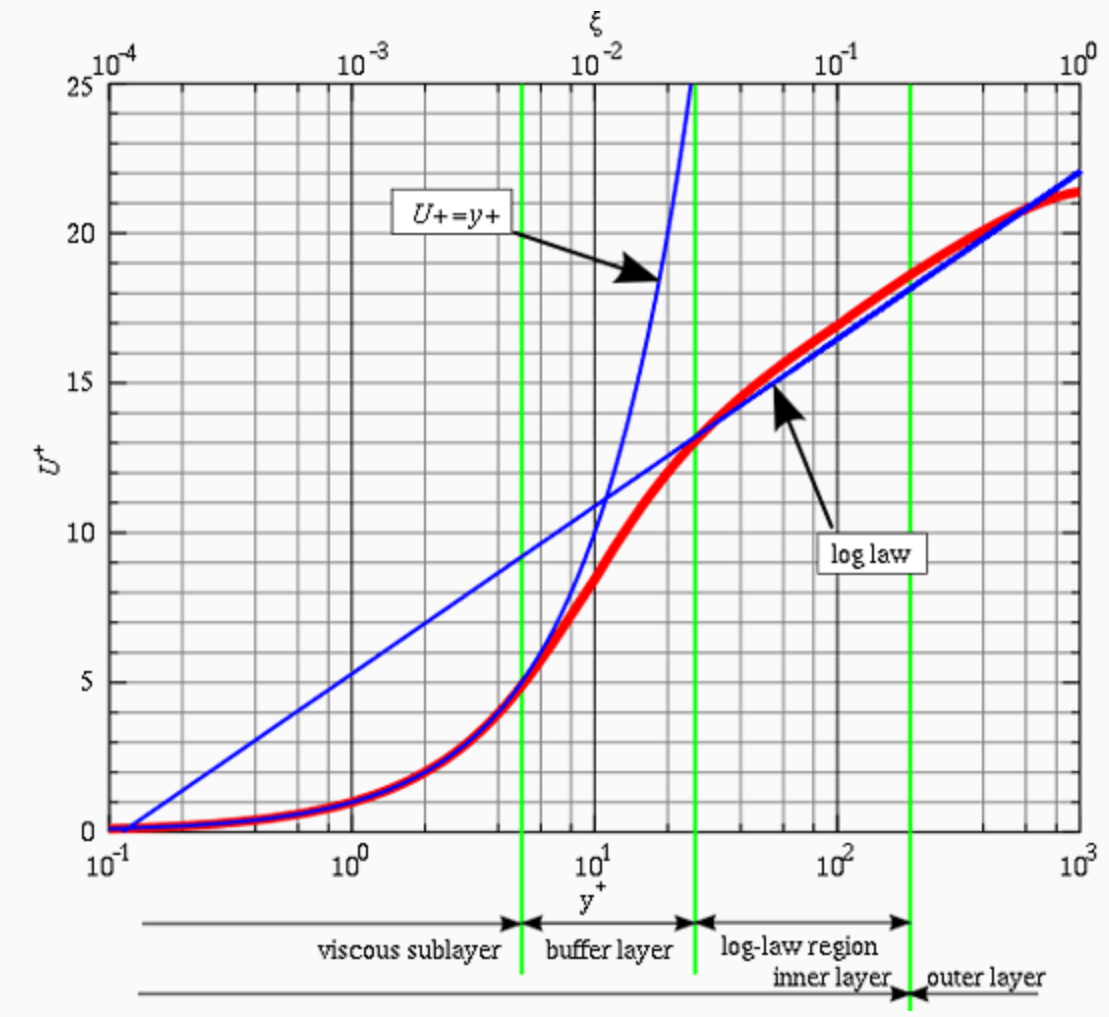

In [16]:
order = 5
y_plus_free = 20


eta_all = y_plus_free*L_x_all* Re_x**(-3/4)*Normalised_cell_height_multiplier[order]
eta_sail = y_plus_free*L_x_sail* Re_x_sail**(-3/4)*Normalised_cell_height_multiplier[order]
eta_stern = y_plus_free*L_x_stern* Re_x_stern**(-3/4)*Normalised_cell_height_multiplier[order]

print("eta: ", eta_all, eta_sail, eta_stern)


eta:  0.23348385680988887 0.12590206368266033 0.10097844783259602
